In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import duckdb
from mpl_toolkits import mplot3d 
from mpl_toolkits.mplot3d import Axes3D

# Import required libraries
#import sklearn
import numpy as np
import matplotlib.pyplot as plt

# Dividing dataset into training and testing dataset and standarized the features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.linear_model import SGDClassifier

from sklearn.decomposition import PCA

In [2]:
periodo = 365
USE_CUMSUM = True

grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]

lista_establecimientos = ["Hospital",  "SAPU","SAR", "SUR","CEAR"]
lista_establecimientos_legend = ["Hospital",  "SAPU","SAR", "SUR","CEAR"]
grupos_etarios = ["Menores_1","De_1_a_4","De_5_a_14","De_15_a_64","De_65_y_mas"]



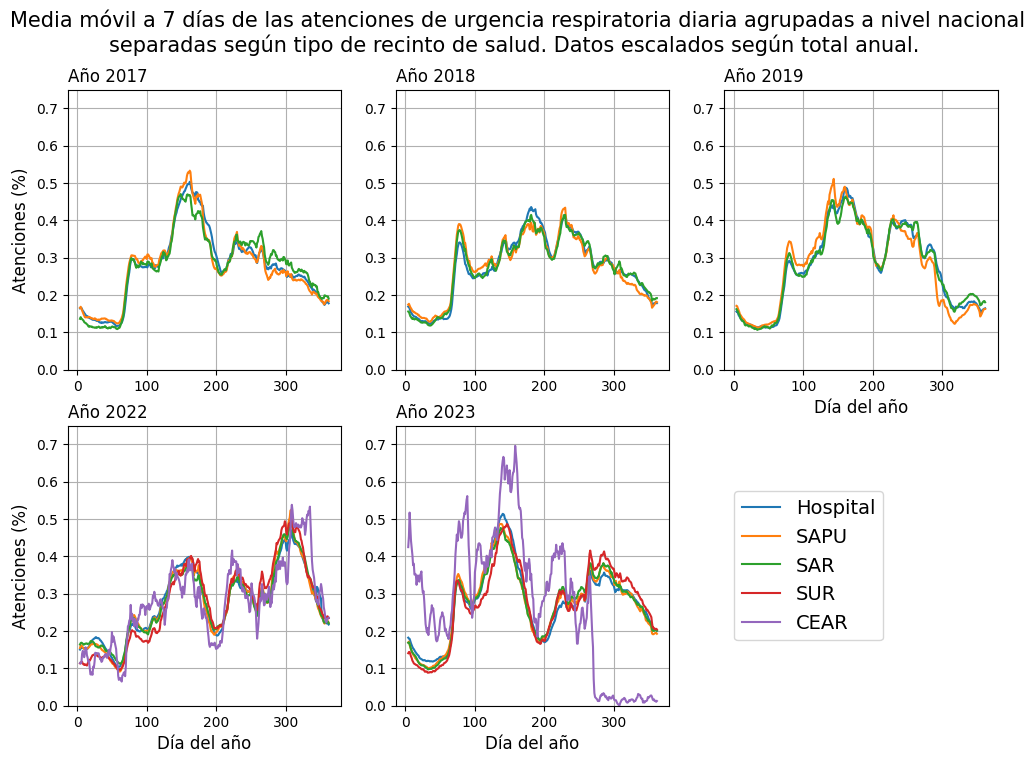

In [3]:
#simple plot of the data agrupados por fecha
df_agrupado_establecimiento = duckdb.sql("""
select GLOSATIPOESTABLECIMIENTO as establecimiento
    , year(strptime(fecha, '%d/%m/%Y')) as year
    , dayofyear(strptime(fecha, '%d/%m/%Y')) as nrodia
--  , fecha
    , sum(Total) as atenciones
FROM datos_urgencia_consolidados.parquet
where IdCausa in (3,4,5,6,10,11)
--and year(strptime(fecha, '%d/%m/%Y')) in (2017,2018,2019,2022,2023)
and CodigoDependencia is not null
and GLOSATIPOESTABLECIMIENTO is not null
--and CodigoDependencia in (9,10,11,12,13,14)
group by  GLOSATIPOESTABLECIMIENTO, fecha
--having dayofyear(strptime(fecha, '%d/%m/%Y')) <= """+ str(periodo) + """
order by establecimiento, fecha
""").df()

#df_agrupado_establecimiento['fecha']= pd.to_datetime(df_agrupado_establecimiento['fecha'],format='%d/%m/%Y')
df = df_agrupado_establecimiento.sort_values(by=['establecimiento','year', "nrodia"]).reset_index(drop=True)

#df = df_agrupado_establecimiento

fig = plt.figure(figsize = (12,8))
fig.suptitle('Media móvil a 7 días de las atenciones de urgencia respiratoria diaria agrupadas a nivel nacional\nseparadas según tipo de recinto de salud. Datos escalados según total anual. ', fontsize=15)

for k, year in enumerate([2017,2018,2019,2022,2023]):
    ax = fig.add_subplot(2,3,k+1) 
    ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
    for establecimiento in lista_establecimientos:
        for column in ['atenciones']:
            filtro_filas = (df["establecimiento"]== establecimiento) & (df["year"]== year) 
            plt.plot(df.loc[filtro_filas,'nrodia'],100*df.loc[filtro_filas,column].rolling(7,center=True).mean()/float(sum(df.loc[filtro_filas,column]))) # c = color)
            #plt.plot(df.loc[filtro_filas,'nrodia'],df.loc[filtro_filas,column].rolling(7,center=True).mean()) # c = color)

            
            ax.set_title('Año ' + str(year), fontsize = 12,loc='left')
            if k in (2,3,4):
                ax.set_xlabel('Día del año', fontsize = 12)
            if k in (0,3):
                ax.set_ylabel('Atenciones (%)', fontsize = 12)
            #ax.set_ylabel('Cantidad hospitalizaciones', fontsize = 12)
            ax.set_ylim(ymin=0)
            ax.set_ylim(ymax=0.75)
            ax.grid()

#show legend in last plot space
ax = fig.add_subplot(2,3,6) 
ax.set_prop_cycle(color = plt.get_cmap("tab10").colors)
for establecimient in lista_establecimientos:
   plt.plot(range(1),range(1))
ax.legend(lista_establecimientos,loc='center left',fontsize = 14 )
ax.axis('off')
#plt.legend(lista_establecimientos)
plt.savefig('fig9_comparacion_tipo_recinto.png', bbox_inches='tight')
 